In [1]:
import sys
!{sys.executable} -m pip install matplotlib seaborn pandas numpy openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [8]:
df = pd.read_csv("data.csv", encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:
df.dropna(inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [10]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [13]:
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,115
1,12347.0,2,7,4310.00,5,5,5,555
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


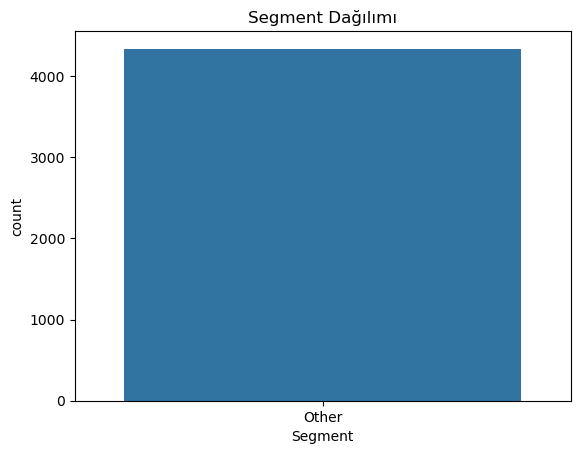

In [14]:
rfm['Segment'] = 'Other'
rfm.loc[(rfm['R']=='5') & (rfm['F']=='5'), 'Segment'] = 'Champions'

sns.countplot(data=rfm, x='Segment')
plt.title("Segment Dağılımı")
plt.show()

In [15]:
def segment_label(rfm_score):
    if rfm_score == '555':
        return 'Champions'
    elif rfm_score[0] in ['4','5'] and rfm_score[1] in ['4','5']:
        return 'Loyal Customers'
    elif rfm_score[0] == '5' and rfm_score[2] in ['4','5']:
        return 'Big Spenders'
    elif rfm_score[0] in ['3','4'] and rfm_score[1] in ['1','2']:
        return 'Potential Loyalist'
    elif rfm_score[0] in ['1','2'] and rfm_score[1] in ['4','5']:
        return 'At Risk'
    elif rfm_score == '111':
        return 'Lost'
    else:
        return 'Others'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_label)
rfm.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,5,115,Others
1,12347.0,2,7,4310.00,5,5,5,555,Champions
2,12348.0,75,4,1797.24,2,4,4,244,At Risk
3,12349.0,19,1,1757.55,4,1,4,414,Potential Loyalist
4,12350.0,310,1,334.40,1,1,2,112,Others
5,12352.0,36,8,2506.04,3,5,5,355,Others
6,12353.0,204,1,89.00,1,1,1,111,Lost
7,12354.0,232,1,1079.40,1,1,4,114,Others
8,12355.0,214,1,459.40,1,1,2,112,Others
9,12356.0,23,3,2811.43,4,3,5,435,Others


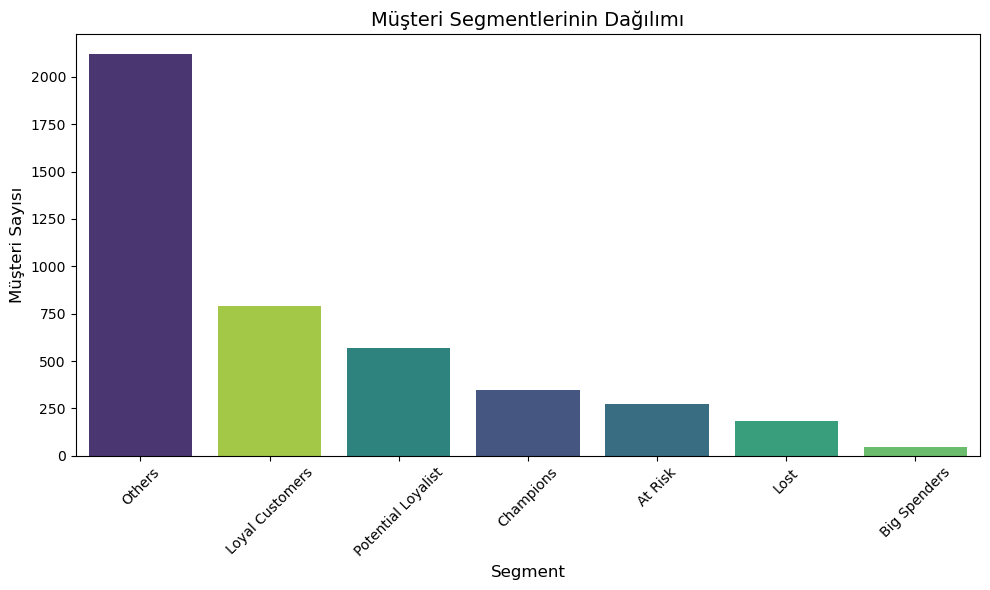

In [19]:
plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x='Segment', hue='Segment', order=rfm['Segment'].value_counts().index, palette="viridis", legend=False)
plt.title('Müşteri Segmentlerinin Dağılımı', fontsize=14)
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Müşteri Sayısı', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

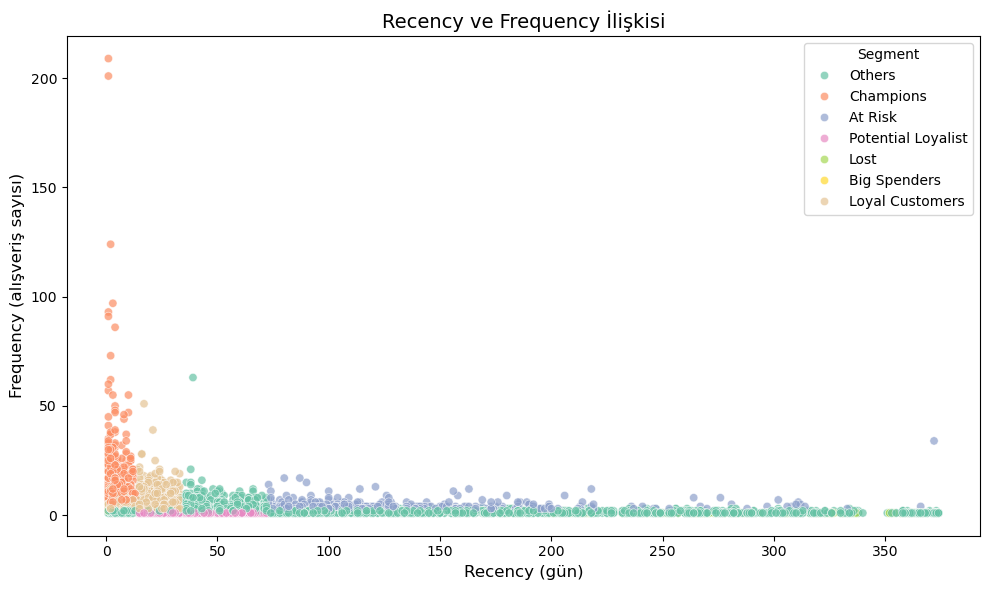

In [20]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette='Set2', alpha=0.7)
plt.title('Recency ve Frequency İlişkisi', fontsize=14)
plt.xlabel('Recency (gün)', fontsize=12)
plt.ylabel('Frequency (alışveriş sayısı)', fontsize=12)
plt.legend(title='Segment', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### 🎯 Segment: Champions
**Tanım:** En son alışverişini yapmış, sık alışveriş yapan, yüksek harcayanlar  
**Strateji:**  
- VIP sadakat programı  
- Yeni ürünlerde ilk sen! → Erken erişim kampanyaları  
- Kişiselleştirilmiş teklifler & teşekkür mesajları  
- Arkadaş davetinde ekstra ödül

---

### 🧡 Segment: Loyal Customers
**Tanım:** Sık alışveriş yapan, düzenli müşteriler  
**Strateji:**  
- Puan toplama sistemi  
- Kargo bedava veya ikinci üründe %50 indirim  
- Çapraz satış (tamamlayıcı ürün önerisi)  
- E-posta ile haftalık öneriler

---

### 💰 Segment: Big Spenders
**Tanım:** Az alışveriş ama yüksek tutarlar  
**Strateji:**  
- Premium ürün odaklı öneriler  
- Concierge hizmeti veya özel müşteri temsilcisi  
- Kısıtlı sayıda özel koleksiyonlara erişim  
- Yüksek bütçeli kampanyalar için özel indirim

---

### 🌱 Segment: Potential Loyalist
**Tanım:** Sadık hale gelmeye yakın müşteriler  
**Strateji:**  
- Hoş geldin kuponları  
- Abonelik avantajları tanıtımı  
- Alışveriş sonrası takip e-mail akışı  
- Sadakat puanı başlatma

---

### 🔕 Segment: At Risk
**Tanım:** Önceden aktif ama artık sessizleşmiş  
**Strateji:**  
- “Seni özledik” kampanyası (%20 dönüş indirimi)  
- Son alışverişine göre özel öneriler  
- Anket ile geri bildirim + indirim  
- Zaman sınırlı teklifler

---

### ⚠️ Segment: Lost
**Tanım:** Çok uzun süredir alışveriş yapmayan  
**Strateji:**  
- Geri kazanım kampanyaları (“Birlikte güzel günlerimiz oldu”)  
- Drip e-posta serisi (hatırlatma – teşvik – çözüm)  
- Anket + indirim kombinasyonu  
- Yeni başlayanlara özel teklifler ile yeniden kazanım

---

### 🔬 Segment: Others
**Tanım:** Henüz sınıflanamayan kullanıcılar  
**Strateji:**  
- A/B testlerinin hedef kitlesi  
- Yeni kampanya denemeleri için pilot grup  
- Segment dışı iletişim – keşif odaklı strateji